In [0]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git
!pip install imgaug
%matplotlib inline

fatal: destination path 'Facial-Similarity-with-Siamese-Networks-in-Pytorch' already exists and is not an empty directory.


In [0]:
import os 
import multiprocessing

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Conv2D, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from facial_dataloader import FacialSequence
os.chdir("Facial-Similarity-with-Siamese-Networks-in-Pytorch")

In [0]:
!mv y data/faces/testing/y 

In [0]:
sister = Sequential()
# input: 112x92 images with 1 channels -> (112, 92, 1) tensors.
# this applies 32 convolution filters of size 3x3 each.
sister.add(Conv2D(4, (3, 3), activation='relu', input_shape=(112, 92, 1), padding="same"))
sister.add(BatchNormalization(axis=-1))  # color space

sister.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
sister.add(BatchNormalization(axis=-1))  # color space

sister.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
sister.add(BatchNormalization(axis=-1))  # color space

sister.add(Flatten())
sister.add(Dense(64, activation='relu'))
sister.add(Dense(8))
sister.add(BatchNormalization(axis=-1))  # normalized euclidean space

sister1_input = Input(shape=(112, 92, 1))
sister2_input = Input(shape=(112, 92, 1))
sister1_output = sister(sister1_input)
sister2_output = sister(sister2_input)


def L2_custom_layer(siamese_outputs):
    _sister1_output, _sister2_output = siamese_outputs
    return K.sum(K.square(_sister1_output - _sister2_output), axis=1, keepdims=True)  # 0 to 8 after normalization


# note that "output_shape" isn't necessary with the TensorFlow backend
l2_squared = Lambda(L2_custom_layer)([sister1_output, sister2_output])  # l2_squared =pow(l2,2)

siamese = Model(inputs=[sister1_input, sister2_input], outputs=l2_squared)


# K.prod( is_same,axis=-1)
def siamese_loss(is_same, _l2_squared):  # 0 same ,1 different
    return (1 - is_same) * _l2_squared + is_same * K.pow(tf.maximum(0.0, margin - K.sqrt(_l2_squared)), 2.0)
    # return (1 - is_same) * _l2_squared + is_same * K.pow(tf.maximum(0.0, -2.0), 2.0)


batch_size = 256
margin = 1.5
epochs = 25
train_enqueuer = FacialSequence(batch_size=batch_size, data_root_path="./data/faces/training")
test_enqueuer = FacialSequence(batch_size=batch_size, data_root_path="./data/faces/testing")
siamese.compile(loss=siamese_loss, optimizer=Adam(lr=10e-6))
siamese.fit_generator(generator=train_enqueuer, steps_per_epoch=40,  # (370 + batch_size - 1) // batch_size,
                      validation_data=test_enqueuer, validation_steps=4,  # (30 + batch_size - 1) // batch_size,
                      epochs=epochs, use_multiprocessing=True, workers=multiprocessing.cpu_count()
                      )

Dataset size 370
Dataset size 39
Epoch 1/25
40/40 [==============================] - 44s 1s/step - loss: 3.2314 - val_loss: 1.0231
Epoch 2/25
40/40 [==============================] - 37s 934ms/step - loss: 1.6231 - val_loss: 0.8662
Epoch 3/25
40/40 [==============================] - 37s 915ms/step - loss: 1.0809 - val_loss: 0.6775
Epoch 4/25
40/40 [==============================] - 37s 930ms/step - loss: 0.8417 - val_loss: 0.6427
Epoch 5/25
40/40 [==============================] - 37s 937ms/step - loss: 0.7391 - val_loss: 0.7592
Epoch 6/25
40/40 [==============================] - 37s 921ms/step - loss: 0.6663 - val_loss: 0.8171
Epoch 7/25
40/40 [==============================] - 38s 941ms/step - loss: 0.5825 - val_loss: 0.8794
Epoch 8/25
40/40 [==============================] - 38s 938ms/step - loss: 0.5451 - val_loss: 1.0443
Epoch 9/25
40/40 [==============================] - 37s 922ms/step - loss: 0.5050 - val_loss: 0.8975
Epoch 10/25
40/40 [==============================] - 37s 927m

['./data/faces/testing/s5/1.pgm',
 './data/faces/testing/s5/4.pgm',
 './data/faces/testing/s5/9.pgm',
 './data/faces/testing/s5/3.pgm',
 './data/faces/testing/s5/10.pgm',
 './data/faces/testing/s5/6.pgm',
 './data/faces/testing/s5/5.pgm',
 './data/faces/testing/s5/8.pgm',
 './data/faces/testing/s5/2.pgm',
 './data/faces/testing/s5/7.pgm',
 './data/faces/testing/s7/1.pgm',
 './data/faces/testing/s7/4.pgm',
 './data/faces/testing/s7/9.pgm',
 './data/faces/testing/s7/3.pgm',
 './data/faces/testing/s7/10.pgm',
 './data/faces/testing/s7/6.pgm',
 './data/faces/testing/s7/5.pgm',
 './data/faces/testing/s7/8.pgm',
 './data/faces/testing/s7/2.pgm',
 './data/faces/testing/s7/7.pgm',
 './data/faces/testing/s6/1.pgm',
 './data/faces/testing/s6/4.pgm',
 './data/faces/testing/s6/9.pgm',
 './data/faces/testing/s6/3.pgm',
 './data/faces/testing/s6/10.pgm',
 './data/faces/testing/s6/6.pgm',
 './data/faces/testing/s6/5.pgm',
 './data/faces/testing/s6/8.pgm',
 './data/faces/testing/s6/2.pgm',
 './data/fa

(39, 112, 92, 1)
(39, 112, 92, 1)


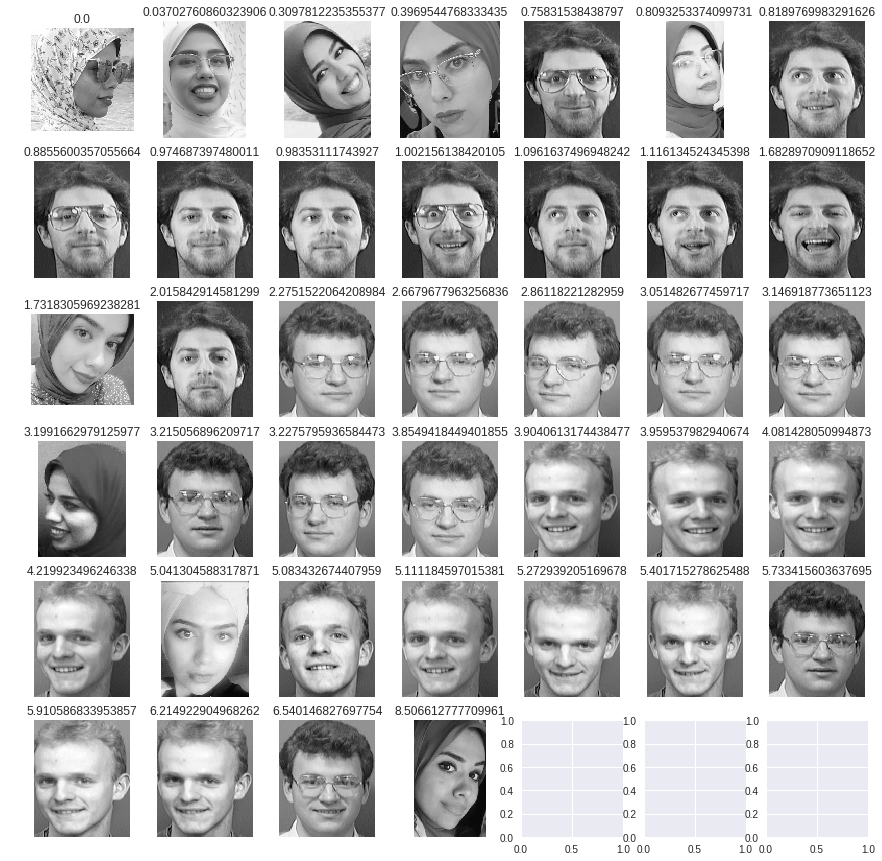

In [0]:
#query_image = './data/faces/testing/s7/5.pgm'  # jpg pgm
query_image = './data/faces/testing/y/10.jpg'  # jpg pgm

# preview raw data
def preview_predictions(predictions):
    # 3 channels
    fig, axeslist = plt.subplots(ncols=7, nrows=6, figsize=(15, 15))

    for i, (path, score) in enumerate(predictions):
        axeslist.ravel()[i].imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY), cmap="gray")
        axeslist.ravel()[i].set_title(score)
        axeslist.ravel()[i].set_axis_off()


#that_images = sorted(list(filter(lambda item: "y" not in item, test_enqueuer.get_data_source())))
that_images = sorted(test_enqueuer.get_data_source())

that_batch = []
for that_image in that_images:
    that_batch.append(cv2.resize(cv2.cvtColor(cv2.imread(that_image), cv2.COLOR_BGR2GRAY), (92, 112)))
that_batch = np.expand_dims(np.array(that_batch), axis=-1).astype(np.float32) / 255.0
print(that_batch.shape)

this_image = np.expand_dims(cv2.resize(cv2.cvtColor(cv2.imread(query_image), cv2.COLOR_BGR2GRAY), (92, 112)), axis=0)
this_batch = np.expand_dims(np.repeat(this_image, len(that_images), axis=0), axis=-1).astype(np.float32) / 255.0
print(this_batch.shape)

query_predictions = sorted(list(zip(that_images, siamese.predict([this_batch, that_batch])[:, 0].tolist())), key=lambda item: item[1])
preview_predictions(query_predictions)


In [0]:
%%writefile facial_dataloader.py
"""
Data:git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git
path:Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training
path:Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing
0 same ,1 different
"""

import os
import random

import cv2
import numpy as np
from imgaug import augmenters as iaa
from tensorflow import keras

seq = iaa.Sequential([

    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Sometimes(0.9, iaa.Crop(percent=((0.0, 0.15), (0.0, 0.15), (0.0, 0.15), (0.0, 0.15)))),  # random crops top,right,bottom,left
    # some noise
    iaa.Sometimes(0.5, [iaa.GaussianBlur(sigma=(0, 0.25)), iaa.Sharpen(alpha=(0.0, .1), lightness=(0.5, 1.25)), iaa.Emboss(alpha=(0.0, 1.0), strength=(0.05, 0.1))]),
    iaa.Sometimes(.7, iaa.Add((-10, 10), per_channel=0)),
    iaa.Scale({"height": 112, "width": 92})

], random_order=True)  # apply augmenters in random order


class FacialSequence(keras.utils.Sequence):
    def __init__(self, data_root_path, batch_size, augmenter=seq):
        """get data structure to load data"""
        # list of (images paths,image root path index(person))
        self.data_source = []

        person_id = 0
        for root, dirs, files in os.walk(data_root_path):  # this will do the dfs for you so you can get every single file and directory
            # this is a person
            if files and not dirs:
                for file in files:
                    self.data_source.append((os.path.join(root, file), person_id))
                person_id += 1

        print("Dataset size", len(self.data_source))
        # pprint(self.data_source)
        self.batch_size = batch_size

        self.augmenter = augmenter

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return (len(self.data_source) + self.batch_size - 1) // self.batch_size  # ceiling div

    def get_actual_length(self):
        """Denotes the total data_to_load of samples"""
        return len(self.data_source)

    def get_pair_of_images(self, is_required_different):  # 0 same ,1 different
        while True:
            first, second = random.choice(self.data_source), random.choice(self.data_source)
            first_label, second_label = first[1], second[1]
            is_samples_different = first_label != second_label
            if is_required_different == is_samples_different:
                # print(is_required_different, first[0], second[0])
                return cv2.cvtColor(cv2.imread(first[0]), cv2.COLOR_BGR2GRAY), \
                       cv2.cvtColor(cv2.imread(second[0]), cv2.COLOR_BGR2GRAY)

    def __getitem__(self, _):
        """Gets one batch"""
        sister1_batch = []
        sister2_batch = []
        labels_batch = np.zeros((self.batch_size,)).astype(np.float32)

        for sample in range(self.batch_size):
            label = random.randint(0, 1)  # 0 same ,1 different.. uniform distribution of course
            sister1, sister2 = self.get_pair_of_images(label)
            sister1_batch.append(sister1)
            sister2_batch.append(sister2)
            labels_batch[sample] = label

        # [batch,height,width,1],[batch,height,width,1],[batch,]
        return [
                   np.expand_dims(np.array(self.augmenter.augment_images(sister1_batch), dtype=np.float32) / 255.0, axis=-1),
                   np.expand_dims(np.array(self.augmenter.augment_images(sister2_batch), dtype=np.float32) / 255.0, axis=-1),
               ], np.reshape(labels_batch,(-1))

    def get_data_source(self):
        return list(map(lambda item: item[0], self.data_source))


if __name__ == '__main__':

    train_loader = FacialSequence(data_root_path="./data/faces/training",
                                  batch_size=1)

    test_loader = FacialSequence(data_root_path="./data/faces/testing",
                                 batch_size=1)
    loader = test_loader
    sss = 0
    for i in range(1000):
        sample = loader[i]
        s1, s2 = sample[0]
        labels = sample[1]
        s1, s2, labels = s1[0], s2[0], labels[0]

        # # VIEW TEST
        # cv2.namedWindow("s1".format(i), cv2.WINDOW_NORMAL)
        # cv2.moveWindow("s1".format(i), 0, 0)
        # cv2.imshow("s1".format(i), s1)
        #
        # cv2.namedWindow("s2".format(i), cv2.WINDOW_NORMAL)
        # cv2.moveWindow("s2".format(i), 400, 400)
        # cv2.imshow("s2".format(i), s2)
        #
        # print(labels)
        # cv2.waitKey()

        # BALANCE TEST
        sss += labels
        if i % 100 == 0:
            print(i)

    print(sss, 10000 / 2)


Writing facial_dataloader.py
